# CMS Synthetic Claims Public Use Files Exploration

This notebook includes code that aggregates and explores the claims files included in the 2008-2010 synthetic public use files. More information about the dataset can be found here: https://www.cms.gov/data-research/statistics-trends-and-reports/medicare-claims-synthetic-public-use-files/cms-2008-2010-data-entrepreneurs-synthetic-public-use-file-de-synpuf

In [103]:
import holidays
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F



In [104]:
data_root_path = "sample1/raw"

file_name_map = {
    'DE1_0_2009_Beneficiary_Summary_File_Sample_1.csv': '2009_Beneficiary_Summary', 
 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv': 'Inpatient_Claims', 
 'DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv': '2008_Beneficiary_Summary', 
 'DE1_0_2010_Beneficiary_Summary_File_Sample_1.csv': '2010_Beneficiary_Summary', 
 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_1.csv': 'Outpatient_Claims',
}


In [109]:
spark = SparkSession.builder.getOrCreate()

ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
dataframes = {}
for file_name, variable_name in file_name_map.items():
    file_path = os.path.join(data_root_path, file_name)
    dataframes[variable_name] = spark.read.csv(file_path, header=True, inferSchema=True)


In [ ]:
#explore the dataframes
#for variable_name, df in dataframes.items():
#    print(f"Dataframe: {variable_name}")
#    df.show(5)
#    df.printSchema()
#    print("\n")


In [ ]:
#Make Single Beneficiary Dataframe
beneficiary_df = dataframes['2009_Beneficiary_Summary'].union(dataframes['2008_Beneficiary_Summary']).union(dataframes['2010_Beneficiary_Summary'])

#merge beneficiary and claims dataframes
inpatient_claims_df = dataframes['Inpatient_Claims'].join(beneficiary_df, on='DESYNPUF_ID', how='inner')
outpatient_claims_df = dataframes['Outpatient_Claims'].join(beneficiary_df, on='DESYNPUF_ID', how='inner')


In [ ]:
# clean up some columns
inpatient_claims_df = inpatient_claims_df.withColumn("Admission Date", F.to_date(F.col("CLM_ADMSN_DT"), "yyyyMMdd"))

outpatient_claims_df = outpatient_claims_df.withColumn("Admission Date", F.to_date(F.col("CLM_FROM_DT"), "yyyyMMdd"))

## Comparing Claims to Holidays

In [ ]:
def aggregate_claim_date(df1, df2):
    df = df1.select(F.col("Admission Date")).union(df2.select(F.col("Admission Date")))
    return df\
    .groupBy("Admission Date")\
    .agg(F.count("Admission Date").alias("Total_Claims")) \
        .orderBy("Admission Date")

def get_holiday_labels(df):
    us_holidays = holidays.US(years=[2008, 2009, 2010])
    holiday_dates = [date for date in us_holidays.keys() if str(date) in df["Admission Date"].astype(str).values]
    return holiday_dates, [us_holidays[date] for date in holiday_dates]

### Claims by Day

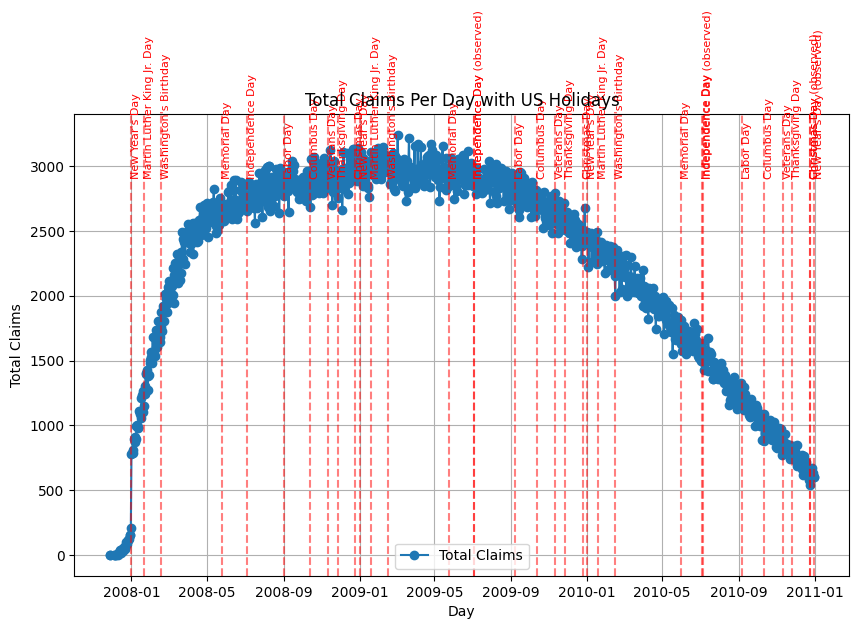

In [ ]:
day_df = aggregate_claim_date(inpatient_claims_df, outpatient_claims_df)

day_pd = day_df.toPandas()
day_pd.loc[day_pd['Total_Claims'] > 0]

holiday_dates, holiday_labels = get_holiday_labels(day_pd)


plt.figure(figsize=(10, 6))
plt.plot(day_pd["Admission Date"], day_pd["Total_Claims"], marker="o", linestyle="-", label="Total Claims")

# Annotate holidays
for date, label in zip(holiday_dates, holiday_labels):
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.5)  # Add vertical lines for holidays
    plt.text(date, max(day_pd["Total_Claims"]) * 0.9, label, rotation=90, fontsize=8, color="red")  # Add holiday labels

# Add labels and title
plt.title("Total Claims Per Day with US Holidays")
plt.xlabel("Day")
plt.ylabel("Total Claims")
plt.legend()
plt.grid(True)
plt.show()

You can see from the graph that claims seem to peak between 2008-05 and 2010-01. I expect that this has something to do with administration of the claims rather than actual trends.

# Exploring Diagnosis Codes

In [ ]:
diagnosis_df = inpatient_claims_df.withColumn("DX_CODE", F.col("ICD9_DGNS_CD_1")).select(F.col("DX_CODE"))

for i in range(2,11):
    diagnosis_df = diagnosis_df.union(inpatient_claims_df.withColumn("DX_CODE", F.col(f"ICD9_DGNS_CD_{i}")).select(F.col("DX_CODE")))

In [ ]:
icd9_pd = pd.read_excel("sample1/raw/CMS32_DESC_LONG_SHORT_DX.xlsx")
icd9_df = spark.createDataFrame(icd9_pd)
icd9_df = icd9_df.withColumn("DX_CODE", F.col("Diagnosis Code").cast("int"))


ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:

agg_dx_df = diagnosis_df.groupBy("DX_CODE")\
    .agg(F.count("DX_CODE")\
         .alias("Total_Claims"))\
            .orderBy("Total_Claims", ascending=False)

merge_dx_df = agg_dx_df.join(icd9_df, agg_dx_df.DX_CODE == icd9_df.ICD9_DGNS_CD, how="left")

In [ ]:
#merge_dx_df.show()

#icd9_df.filter(F.col("ICD9_DGNS_CD") == 55321).show()

icd9_pd

,ICD9_DGNS_CD,ICD9_DESC
0,0010,Cholera d/t vib cholerae
1,0011,Cholera d/t vib el tor
2,0019,Cholera NOS
3,0020,Typhoid fever
4,0021,Paratyphoid fever a
...,...,...
14562,V9129 Quad gest-plac/sac undet,None
14563,V9190 Mult gest-plac/sac NOS,None
14564,V9191 Mult gest 2+ monochr NEC,None
14565,V9192 Mult gest 2+ monoamn NEC,None


25/04/07 11:52:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 615165 ms exceeds timeout 120000 ms
25/04/07 11:52:19 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/07 11:52:29 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$